In [40]:
# Import Necessary Libraries

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

import pickle

# Domain Knowledge

![Alt text](<Term Deposit.png>)

A term deposit is a fixed-term investment that includes the deposit of money into an account at a financial institution. Term deposit investments usually carry short-term maturities ranging from one month to a few years and will have varying levels of required minimum deposits. The investor must understand when buying a term deposit that they can withdraw their funds only after the term ends. In some cases, the account holder may allow the investor early termination—or withdrawal—if they give several days notification. Also, there will be a penalty assessed for early termination.

![Alt text](<Bank Funding Lending.png>)

When an account holder deposits funds at a bank, the bank can use that money to lend to other consumers or businesses. In return for the right to use these funds for lending, they will pay the depositor compensation in the form of interest on the account balance. With most deposit accounts of this nature, the owner may withdraw their money at any time. This makes it difficult for the bank to know ahead of time how much they may lend at any given time.<br><br>
To overcome this problem, banks offer term deposit accounts. A customer will deposit or invest in one of these accounts, agreeing not to withdraw their funds for a fixed period in return for a higher rate of interest paid on the account. The interest earned on a term deposit account is slightly higher than that paid on standard savings or interest-bearing checking accounts. The increased rate is because access to the money is limited for the timeframe of the term deposit. If a customer places money in a term deposit, the bank can invest the money in other financial products that pay a higher rate of return (RoR) than what the bank is paying the customer for the use of their funds. The bank can also lend the money out to its other clients, thereby receiving a higher interest rate from the borrowers as compared to what the bank is paying in interest for the term deposit.<br><br>
For example, a lender may offer a 2% rate for term deposits with a two-year maturity. The funds deposited are then structured as loans to borrowers who are charged 7% in interest on those notes. This difference in rates means that the bank makes a net 5% return. The spread between the rate the bank pays its customers for deposits and the rate it charges its borrowers is called net interest margin. Net interest margin is a profitability metric for banks.<br><br>
Banks are businesses, as such, they want to pay the lowest rate possible for term deposits and charge a much higher rate to borrowers for loans. This practice increases their margins or profitability. However, there is a balance the bank needs to maintain. If it pays too little interest, it won't attract new investors into the term deposit accounts. Also, if they charge too high of a rate on loans, it won't attract new borrowers.


# Business Problem

**Business Problem: Improving Term Deposit Marketing**

**Background:**
Our bank conducts marketing campaigns to promote term deposits to customers. To make these campaigns more efficient, we want to use machine learning to predict which customers are likely to subscribe to a term deposit after being contacted.

**Problem Statement:**
We want to create a system that helps us decide which customers to target in our marketing campaigns for term deposits. This system will predict if a customer is likely to say "yes" or "no" to a term deposit offer.

**Data Availability:**
We have data from past marketing campaigns, including information about customers and whether they subscribed to a term deposit or not.

**Key Objectives:**
1. Build a system that predicts whether a customer will subscribe to a term deposit.
2. Use this system to select the right customers for marketing campaigns.
3. Improve the efficiency of our marketing efforts and save costs.

**Benefits:**
Implementing this system will:
- Increase the chances of reaching customers who are likely to subscribe.
- Reduce marketing costs by not targeting customers who are unlikely to subscribe.
- Help us tailor our marketing strategies based on customer behavior.

# Data Understanding

In [41]:
# Read data(csv) and make into dataframe
df = pd.read_csv('data_bank_marketing_campaign.csv')
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


Customer Profile:
1. age: Customer's Age
2. job: Customer's Job
3. balance: Balance of the individual
4. housing: Is the customer currently has housing loan?
5. loan: Is the customer currently has personal loan?

Marketing Data:
1. contact: Contact communication type
2. month: Last contact month of year
3. campaign: Number of contacts performed during this campaign and for this customer
4. pdays: Number of days that passed by after the customer was last contacted from a previous campaign
5. poutcome: Outcome of the previous marketing campaign

Output variable (desired target):
1. deposit: Whether has the client subscribed a term deposit or not?

# EDA (Exploratory Data Analysis)

## EDA (Exploratory Data Analysis) - Numerical data

In [42]:
# Indentify each numerical data range
df.describe().loc[['min','max']]

,age,balance,campaign,pdays
min,18.0,-6847.0,1.0,-1.0
max,95.0,66653.0,63.0,854.0


From the dataframe above, we found anomalies in pdays where the minimum value is -1. This occurs because a value of -1 indicates that the customer hasn't been contacted since the previous campaign. Since pdays represents the number of days that passed after the customer was last contacted in a previous campaign and -1 values effectively represent a categorical type (indicating that the customer has never been contacted since the previous campaign), while positive values are treated as numeric data representing the number of days. This creates a situation where pdays has two types of data: numerical for positive values and categorical for -1.<br><br>
To solve this problem, pdays needs to be changed into a categorical feature with two categories.<br>
The categories are:
- 'yes' which stands for customers who have been contacted and will replace any positive values in pdays
- 'no' which stands for customers who have not been contacted and will replace -1 values in pdays.<br>

Lastly, pdays feature should be renamed as pcontact.

In [43]:
# Replace positive values in pdays with 'yes' and -1 with 'no'
df['pdays']=np.where(df['pdays']==-1,'no','yes')
# Rename pdays to pcontact
df.rename(columns={'pdays': 'pcontact'}, inplace=True)

## EDA (Exploratory Data Analysis) - Categorical Data

In [44]:
# Value counts each categorical data

value_counts_dict = {}

for col in df.columns:                                                  # Value count each categorical data by looping and save it in a dictionary
    if df[col].dtype == 'object' or df[col].dtype == 'category':
        value_counts_dict[col] = df[col].value_counts()

for col, value_counts in value_counts_dict.items():                     # Print each categorical data by looping
    print(f"Value counts for column '{col}':\n{value_counts}\n")

Value counts for column 'job':
job
management       1792
blue-collar      1346
technician       1291
admin.            936
services          658
retired           540
self-employed     280
unemployed        249
student           247
entrepreneur      236
housemaid         184
unknown            54
Name: count, dtype: int64

Value counts for column 'housing':
housing
no     4140
yes    3673
Name: count, dtype: int64

Value counts for column 'loan':
loan
no     6789
yes    1024
Name: count, dtype: int64

Value counts for column 'contact':
contact
cellular     5628
unknown      1639
telephone     546
Name: count, dtype: int64

Value counts for column 'month':
month
may    1976
aug    1085
jul    1050
jun     857
apr     662
nov     657
feb     534
oct     286
jan     227
sep     212
mar     199
dec      68
Name: count, dtype: int64

Value counts for column 'pcontact':
pcontact
no     5817
yes    1996
Name: count, dtype: int64

Value counts for column 'poutcome':
poutcome
unknown    5819
f

In case the output is truncated and you are unable to open the output in a text editor, I have provided the complete output in pictures below. At the same time, I highlighted two values: 'unknown' and 'other' in each categorical data.

![Alt text](Categorical_Count_1.png)

![Alt text](Categorical_Count_2.png)

From pictures above the categorical data that has 'unknown' and 'other' are as follows:
- 'unknown' = ['job', 'contact', 'poutcome']
- 'other'   = ['poutcome']

**'unknown' in job:**<br>
'unknown' in 'job' indicates that the customer's job is currently unknown, and there are 54 customers with 'unknown' job. 'unknown' in job is actually missing values. Since there are only 54 customers with 'unknown' job out of a total of 7813 customers, excluding the customer data with 'unknown' job would have minimal impact on the overall analysis.

In [45]:
# Removing any customer with 'unknown' job
df = df[~df['job'].isin(['unknown'])].reset_index(drop=True)

**'unknown' in contact:**<br>
unknown' in 'contact' indicates that the contact communication type is currently unknown, and there are 1639 customers with 'unknown' contact. 'unknown' in contact is actually missing values. Since there are 1639 customers with 'unknown' contact out of a total of 7813 customers, representing a very significant proportion of the total customer data, these records cannot be excluded or imputed with the mode values. To solve this problem, it is best to change 'unknown' to a new category named 'other'.

In [46]:
# Replace 'unknown' with 'other' in contact
df['contact'].replace(['unknown'], ['other'], inplace=True)

**'unknown' and 'other' in poutcome:**<br>
Since poutcome is the outcome of the previous marketing campaign, the result can only be 3 values which is 'success' ,'failure' and 'unknown'. On the other hand, there is 'other' in poutcome. I assume when data is collected the staff input either 'unknown' or 'other' when the outcome in not known. To handle this situation, it is best to replace 'other' with 'unknown'.

In [47]:
# Replace 'other' with 'unknown' in poutcome
df['poutcome'].replace(['other'], ['unknown'], inplace=True)

# Data Preprocessing

In [48]:
df['deposit'].unique()

array(['yes', 'no'], dtype=object)

In [49]:
# Changing deposit (target) into binary numbers [1 for yes] and [0 for no]
df['deposit'] = np.where(df['deposit']=='yes',1,0).astype('int64')

In [50]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pcontact,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,no,unknown,1
1,39,self-employed,-3058,yes,yes,cellular,apr,3,no,unknown,1
2,51,admin.,3025,no,no,cellular,may,1,yes,unknown,1
3,38,services,-87,yes,no,cellular,may,1,no,unknown,0
4,36,housemaid,205,yes,no,telephone,nov,4,no,unknown,0


## Data Preprocessing - Data Type

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7759 entries, 0 to 7758
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7759 non-null   int64 
 1   job       7759 non-null   object
 2   balance   7759 non-null   int64 
 3   housing   7759 non-null   object
 4   loan      7759 non-null   object
 5   contact   7759 non-null   object
 6   month     7759 non-null   object
 7   campaign  7759 non-null   int64 
 8   pcontact  7759 non-null   object
 9   poutcome  7759 non-null   object
 10  deposit   7759 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 666.9+ KB


There isn't any inappropriate data type

## Data Preprocessing - Mischaracterization

In [52]:
# Print each unique categorical data

unique_dict = {}

for col in df.columns:                                                  # Search for unique categorical data by looping and save it in a dictionary
    if df[col].dtype == 'object' or df[col].dtype == 'category':
        unique_dict[col] = df[col].unique()

for col, unique in unique_dict.items():                                 # Print each unique categorical data by looping
    print(f"'{col}' unique:\n{unique}\n")

'job' unique:
['admin.' 'self-employed' 'services' 'housemaid' 'technician' 'management'
 'student' 'blue-collar' 'entrepreneur' 'retired' 'unemployed']

'housing' unique:
['no' 'yes']

'loan' unique:
['no' 'yes']

'contact' unique:
['cellular' 'telephone' 'other']

'month' unique:
['jun' 'apr' 'may' 'nov' 'jan' 'sep' 'feb' 'mar' 'aug' 'jul' 'oct' 'dec']

'pcontact' unique:
['no' 'yes']

'poutcome' unique:
['unknown' 'failure' 'success']



From the output we can conclude that there isn't any value that has mischaracterization in each categorical feature.

## Data Preprocessing - Duplicate Data

In [53]:
# Identify how many duplicate data

df.duplicated().sum()

8

In [54]:
# Delete all duplicate data

df.drop_duplicates(inplace= True)

## Data Preprocessing - Outliers

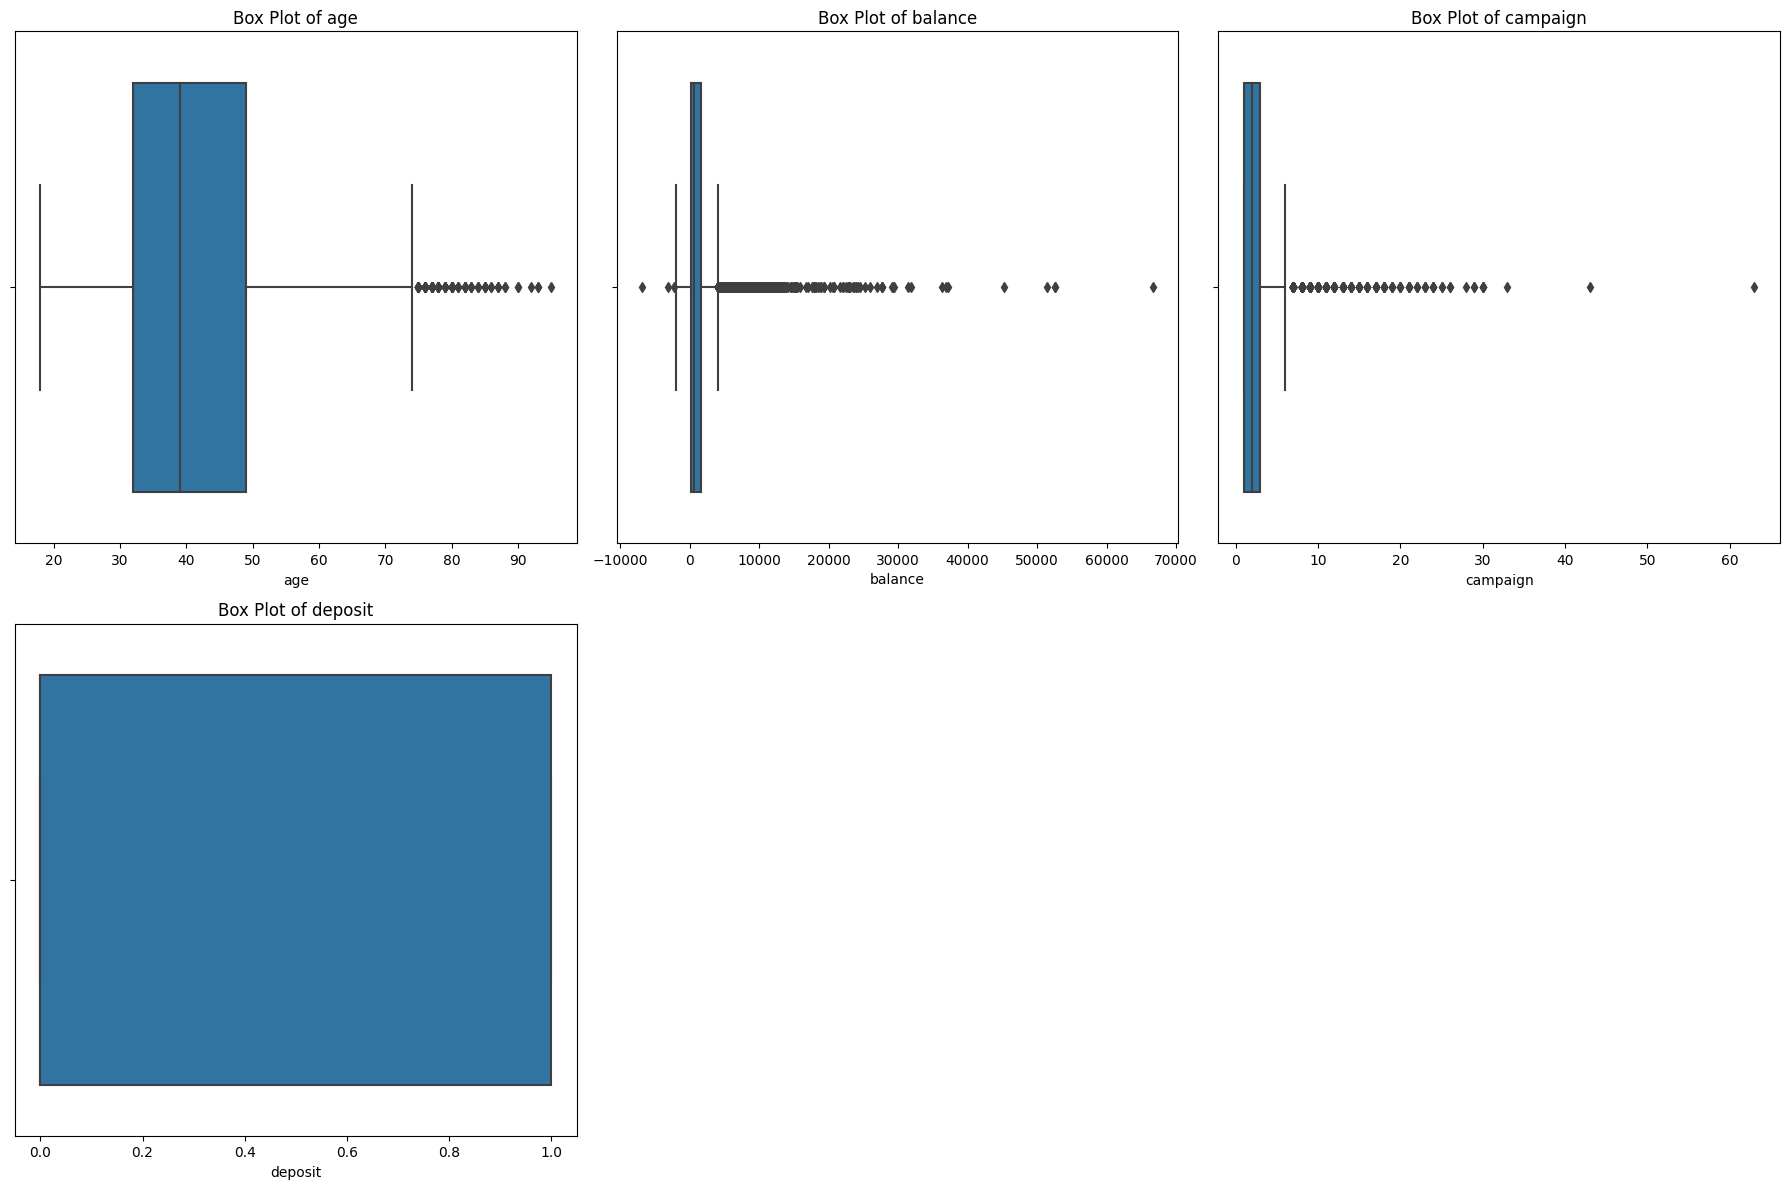

In [55]:
def numerical_boxplots(data):                                                           # Define function to create boxplot for each numerical data
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    num_plots = len(numerical_columns)
    num_rows = (num_plots + 2) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
    axes = axes.ravel()                                                                 # Flatten the 2D array of axes

    for i, column in enumerate(numerical_columns):                                      # Create boxplot for each numerical data by looping
        sns.boxplot(data=data, x=column, ax=axes[i])
        axes[i].set_title(f'Box Plot of {column}')

    # Hide any empty subplots
    for i in range(num_plots, num_rows * 3):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


numerical_boxplots(df)

From each boxplot above, there isn't any necesarry to remove outliers. This beacuse all the values contain valuable information that doesn't affect classification negatively.

# Define Target and Features

In [56]:
target = 'deposit'                          # Store 'deposit' in target variable
y = df[target]                              # Define target
X = df.drop(columns=[target])               # Define features

# Data Splitting

In [57]:
# Split data into 80 % train set and 20 % test set, also spread the target values evenly between train set and test set using stratify=y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify= y)

# EDA for Classification

## EDA for Classification - Balanced or Imbalanced

In [58]:
p_class1 = (df[target].value_counts()/len(df))[0]                       # Calculate positive class's (1) proportion
p_class2 = (df[target].value_counts()/len(df))[1]                       # Calculate negative class's (0) proportion


if p_class1<=0.4 or p_class2<=0.4:                                      # Print result
    print(f'Target is imbalanced\n')
else:
    print(f'Target is balanced\n')

if p_class1>p_class2:
    print(f"{(df[target].unique())[0]} is majority, ({(df[target].value_counts())[0]}) counts and it\'s Proportion = {round(p_class1*100)} %")
    print(f"{(df[target].unique())[1]} is minority, ({(df[target].value_counts())[1]}) counts and it\'s Proportion = {round(p_class2*100)} %")
else:
    print(f"{(df[target].unique())[1]} is majority, ({(df[target].value_counts())[1]}) counts and it\'s Proportion = {round(p_class2*100)} %")
    print(f"{(df[target].unique())[0]} is minority, ({(df[target].value_counts())[0]}) counts and it\'s Proportion = {round(p_class1*100)} %")


Target is balanced

1 is majority, (4047) counts and it's Proportion = 52 %
0 is minority, (3704) counts and it's Proportion = 48 %


We can conclude the target is balance since the minority class (0) proportion is above 40%

## EDA for Classification - Missing Values

In [59]:
# Identifying data with missing values.
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

There are no missing values.

## EDA for Classification - Outliers

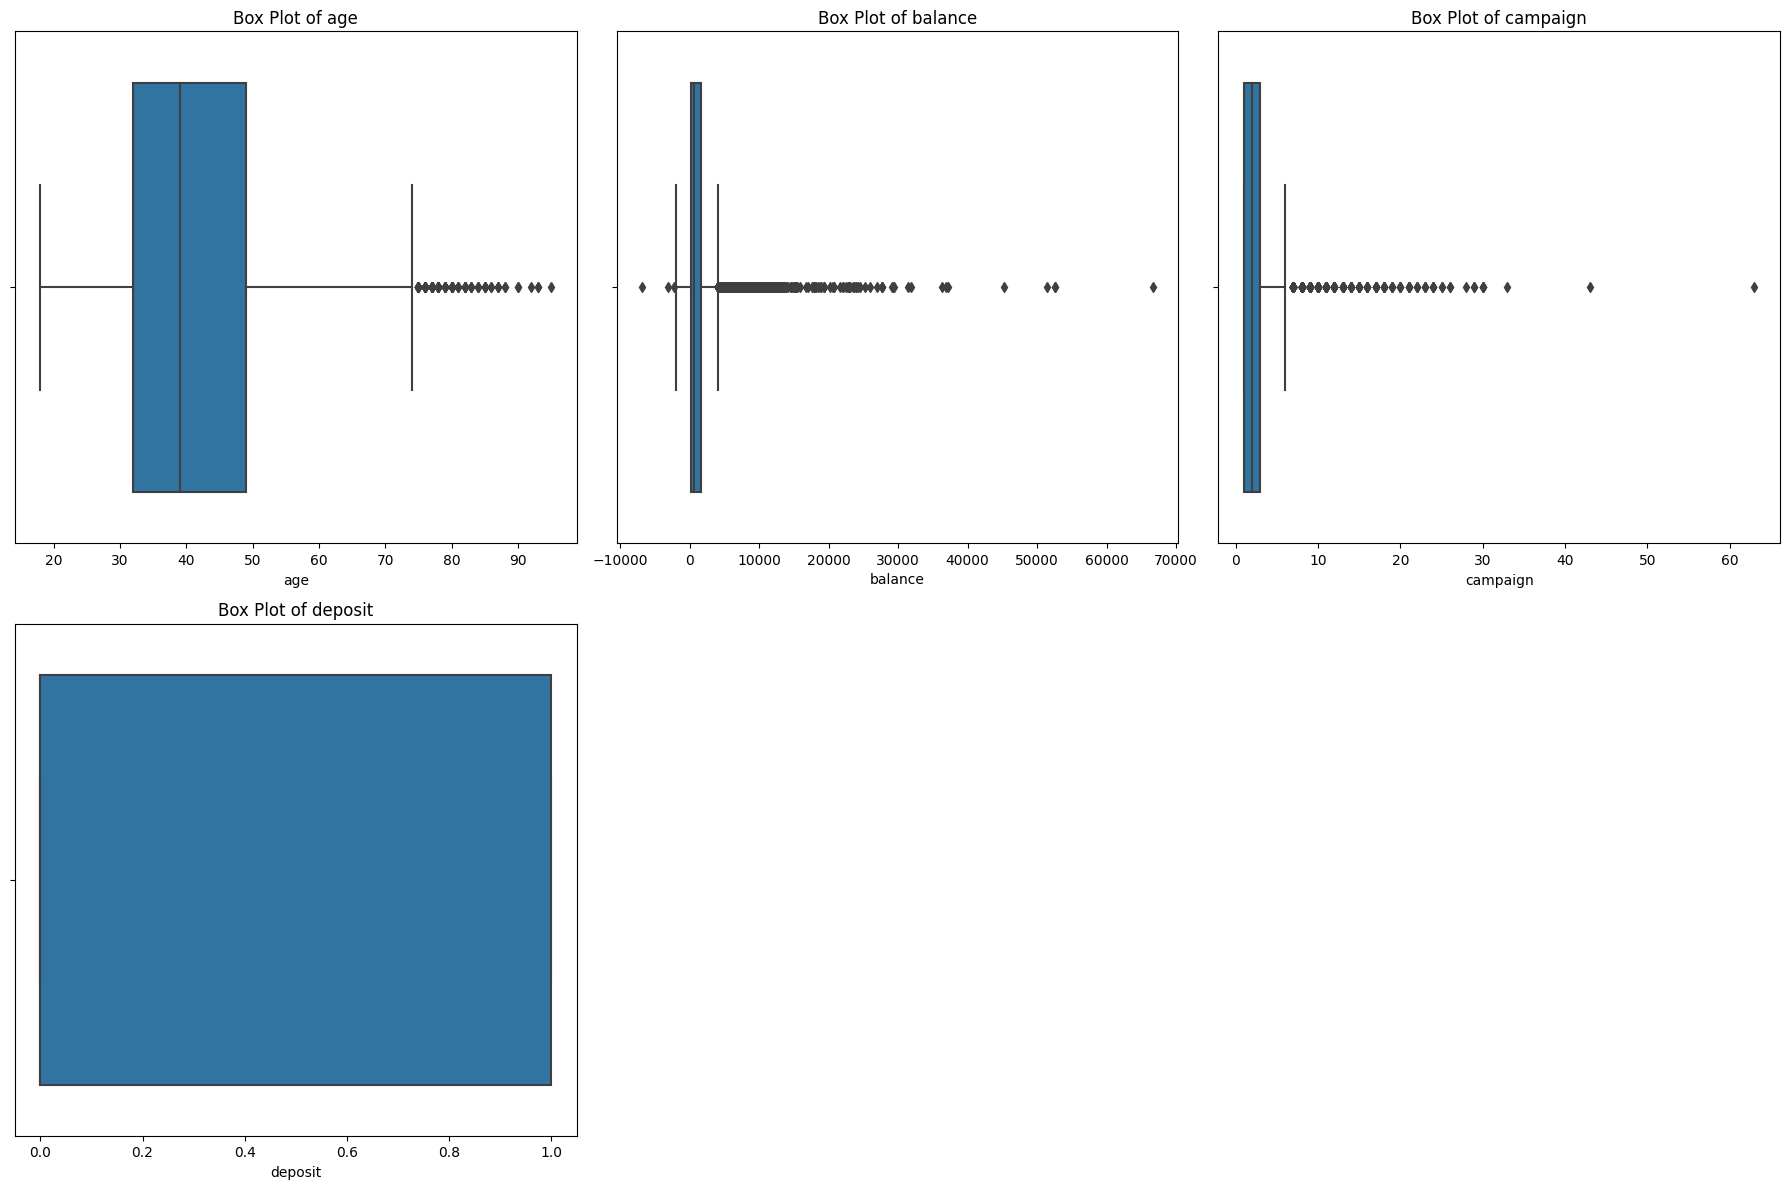

In [60]:
# Create boxplots for all numerical data.
numerical_boxplots(df)

The boxplots above indicate that all numerical features have outliers, while the target variable does not exhibit any outliers.

## EDA for Classification - Linear or Nonlinear Relationship

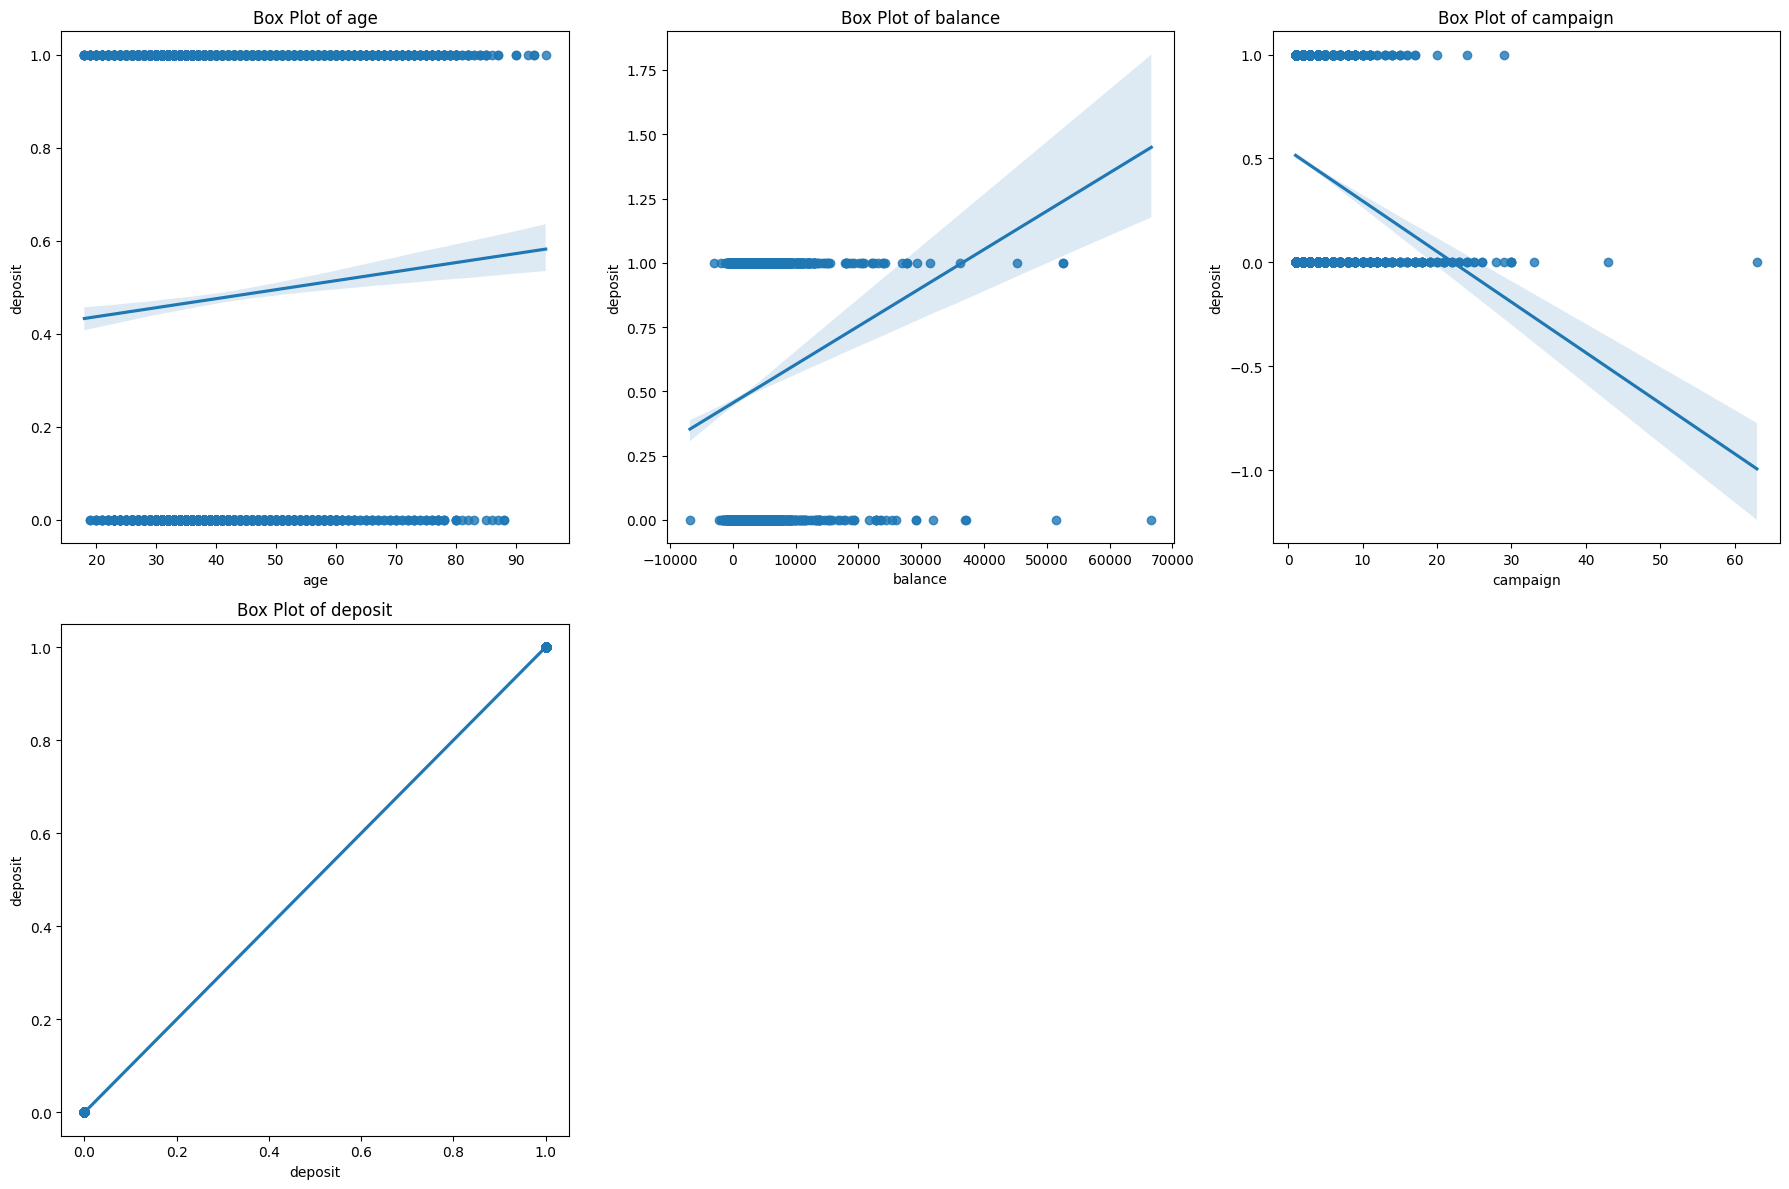

In [61]:
def numerical_regplot(data, y_axis):                                                    # Define function to create regplot for each numerical data
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    num_plots = len(numerical_columns)
    num_rows = (num_plots + 2) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
    axes = axes.ravel()                                                                 # Flatten the 2D array of axes

    for i, column in enumerate(numerical_columns):                                      # Create regplot for each numerical data by looping
        sns.regplot(data=data, x=column, y=y_axis, ax=axes[i])
        axes[i].set_title(f'Box Plot of {column}')

    # Hide any empty subplots
    for i in range(num_plots, num_rows * 3):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

numerical_regplot(df, target)

The regplots above indicate that all numerical features have a nonlinear relationship with the target.

## EDA for Classification - Summary

In summary there are 4 conclusion from EDA for Classification analysis:
1. Target is balanced
2. There are no missing values.
3. All numerical features have outliers, while the target variable does not exhibit any outliers.
4. All numerical features have a nonlinear relationship with the target.

# Classification Performance Metrics

In the context of predicting whether bank customers will take a term deposit or not, false positives and false negatives are two types of prediction errors that can occur when using a classification model. These errors have different implications for the bank and can result in various costs or losses.

1. False Positive:
   - Definition: A false positive occurs when the model predicts that a customer will take a term deposit (positive class), but in reality, the customer does not take a term deposit (negative class).
   - Implication: The bank may allocate resources, such as marketing efforts or incentives, to target customers who are predicted to be interested in a term deposit but are not actually interested. This can lead to unnecessary expenses and a waste of resources.
   - Loss: The loss associated with false positives includes the cost of marketing campaigns, staff time, and any incentives offered to customers who do not end up taking a term deposit. It also affects the bank's return on investment (ROI) for marketing efforts.

2. False Negative:
   - Definition: A false negative occurs when the model predicts that a customer will not take a term deposit (negative class), but in reality, the customer does take a term deposit (positive class).
   - Implication: This type of error can result in missed opportunities for the bank. The bank fails to identify customers who are interested in taking a term deposit, potentially leading to a loss of revenue and the opportunity to build stronger customer relationships.
   - Loss: The loss associated with false negatives includes the revenue the bank could have earned from term deposits that were missed, as well as the potential for long-term customer loyalty and additional business opportunities with those customers.

The choice between minimizing false positives or false negatives depends on the specific business goals and priorities of the bank:
- If the bank wants to minimize the risk of wasting resources and prefers not to bother customers unnecessarily, it may prioritize reducing false positives.
- If the bank wants to maximize revenue and customer engagement, it may prioritize reducing false negatives to identify and target potential term deposit customers more effectively.

In practice, the balance between false positives and false negatives is often controlled by adjusting the model's classification threshold. By changing the threshold, the bank can fine-tune the model's predictions to better suit its business objectives, trading off between these two types of errors.

## Classification Performance Metrics - False Positive

The cost associated with false positives includes expenses such as marketing campaigns, staff time, and any incentives offered to customers who do not end up subscribing to a term deposit. In real-world scenarios, calculating this cost precisely can be challenging. Often, marketing budgets, staff salaries, and incentives are already accounted for in the budget, making the loss in the false negative case relatively insignificant to calculate. Even though all of that, let's assume the loss in the false negative case is Rp 500,000.

## Classification Performance Metrics - False Negative

![Alt text](<Suku Bunga Deposit.png>)

![Alt text](<Suku Bunga Pinjaman Juni 2023.png>)

The first of the two pictures above illustrates a term deposit interest rate of 2% for a term deposit of Rp 50,000,000 with a duration of 12 months in BCA Bank. In real cases, interest rates vary among banks, customers, loan amounts, and deposit durations. To calculate the potential false negative error, we will assume a general interest rate for term deposits of 2.0% and a standard term deposit amount of Rp 50,000,000.

The second picture displays various lending interest rates for different customer categories. Given that the majority of loans in banks are extended to corporations, we will assume a general loan interest rate is 8.4%.

We can determine the loss resulting from a false negative by calculating the missed opportunity for potential customers. This missed opportunity can be calculated by multiplying the loan amount by the bank's net interest margin. The net interest margin can be calculated by subtracting the term deposit interest rate from the bank's loan interest rate.

The loss from a false negative error can be calculated as follows:
- Loss = (Loan amount) * (Loan interest rate - Term deposit interest rate) = Rp 50,000,000 * (8.4% - 2.0%) = Rp 3,200,000.

## Classification Performance Metrics - Summary

In the context of supervised classification, there are various performance metrics to consider. Based on our prior analysis, we have determined that the target class distribution is balanced. Therefore, using accuracy as a performance metric is a safe choice.

However, it's essential to note that the cost associated with false negatives is estimated to be RP 3,200,000, while the cost of false positives is estimated to be RP 500,000. This situation underscores the importance of minimizing false negatives to mitigate the losses resulting from incorrect predictions.

To address this concern, we can utilize recall as a performance metric. This choice is well-suited for our classification problem, as it prioritizes the identification of true positives and minimizes false negatives, aligning with our goal of reducing the significant financial loss associated with these instances."

# Cross Validation

In [62]:
# Since all numerical features have outliers and exhibit a nonlinear relationship with the target, it's appropriate to perform binning followed by One-Hot Encoding.
pipe_bin_one = Pipeline([('bin_one', KBinsDiscretizer(strategy='uniform', n_bins= 5, encode='onehot'))])    # Pipeline for Binning with the Same Interval, 5 Bins, and One-Hot Encoding

pipe_onehot = Pipeline([('onehot',OneHotEncoder())])                                                        # Pipeline for OneHotEncoder
pipe_binary = Pipeline([('binary',BinaryEncoder())])                                                        # Pipeline for BinaryEncoder


transformer = ColumnTransformer([                                                               # Create transformer using ColumnTransformer()
    ('pipe_bin_one',pipe_bin_one,['age', 'balance', 'campaign']),                               # Binning all numerical features using pipe_bin_one
    ('pipe_onehot',pipe_onehot,['housing', 'loan', 'contact', 'pcontact', 'poutcome']),         # Encode all categorical features with few unique values using pipe_onehot
    ('pipe_binary',pipe_binary,['job', 'month'])                                                # Encode all categorical features with lots of unique values using pipe_binary
    ], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipe_bin_one',
                                 Pipeline(steps=[('bin_one',
                                                  KBinsDiscretizer(strategy='uniform'))]),
                                 ['age', 'balance', 'campaign']),
                                ('pipe_onehot',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['housing', 'loan', 'contact', 'pcontact',
                                  'poutcome']),
                                ('pipe_binary',
                                 Pipeline(steps=[('binary', BinaryEncoder())]),
                                 ['job', 'month'])])

In [63]:
# Create machine learning models for cross-validation.
log_reg = LogisticRegression(random_state=0)
knn_class = KNeighborsClassifier()
dec_class = DecisionTreeClassifier(random_state=0)
vot_class = VotingClassifier([('m1',log_reg), ('m2',knn_class), ('m3',dec_class)])
stack_class = StackingClassifier([('m1',log_reg), ('m2',knn_class), ('m3',dec_class)], final_estimator=log_reg)
bagg_class = BaggingClassifier(random_state=0, base_estimator= KNeighborsClassifier())
rand_forest_class = RandomForestClassifier(random_state=0)
adapt_boost_class = AdaBoostClassifier(random_state=0)
grad_boost_class = GradientBoostingClassifier(random_state=0)
xgbc_class = XGBClassifier()


# Create Dataframe to save cross validation score
cross_val_df = pd.DataFrame(columns=['Model','Mean Score','Std Score','Recall','Min Recall'])

# Looping cross validation for each model
for model in [log_reg, knn_class, dec_class, vot_class, stack_class, bagg_class, rand_forest_class, adapt_boost_class, grad_boost_class, xgbc_class]:

    pipe_model = Pipeline([                                                                                 # Utilize pipe_model to prevent any information leakage
        ('preprocessing', transformer),                                                                     # Utilize transformer as preprocessing
        ('modeling', model)                                                                                 # Utilize model as modeling algorithm
        ])

    val_scores = cross_val_score(estimator=pipe_model, X= X_train, y=y_train, cv=5, scoring='recall')       # Utilize 5-fold cross validation with recall as perfomance metrics

    cross_val_df.loc[len(cross_val_df)] = {                                                                 # Save cross validation score in dataframe
        'Model':model,
        'Mean Score': val_scores.mean(),
        'Std Score': val_scores.std(),
        'Recall':np.round(val_scores, 2),
        'Min Recall':np.round(val_scores, 2).min(),}
    
cross_val_df

,Model,Mean Score,Std Score,Recall,Min Recall
0,LogisticRegression(random_state=0),0.597022,0.020210,"[0.61, 0.58, 0.63, 0.59, 0.58]",0.58
1,KNeighborsClassifier(),0.581502,0.025674,"[0.61, 0.54, 0.61, 0.56, 0.59]",0.54
2,DecisionTreeClassifier(random_state=0),0.519394,0.027026,"[0.55, 0.5, 0.54, 0.48, 0.52]",0.48
3,"VotingClassifier(estimators=[('m1', LogisticRe...",0.571710,0.025354,"[0.6, 0.54, 0.6, 0.55, 0.57]",0.54
4,"StackingClassifier(estimators=[('m1', Logistic...",0.590948,0.027556,"[0.62, 0.55, 0.62, 0.57, 0.59]",0.55
5,BaggingClassifier(base_estimator=KNeighborsCla...,0.576437,0.028805,"[0.59, 0.54, 0.62, 0.55, 0.59]",0.54
6,RandomForestClassifier(random_state=0),0.583525,0.025433,"[0.61, 0.55, 0.61, 0.56, 0.59]",0.55
7,AdaBoostClassifier(random_state=0),0.601748,0.016577,"[0.61, 0.58, 0.63, 0.59, 0.59]",0.58
8,GradientBoostingClassifier(random_state=0),0.590261,0.033095,"[0.62, 0.58, 0.63, 0.54, 0.59]",0.54
9,"XGBClassifier(base_score=None, booster=None, c...",0.596013,0.027078,"[0.62, 0.56, 0.63, 0.57, 0.61]",0.56


After performing cross-validation, we found that the AdaBoostClassifier consistently achieved the highest mean score with a low standard deviation, indicating its robust performance. Furthermore, it exhibited one of the two highest minimum recall, comparable to that of LogisticRegression. As a result, we have selected the AdaBoostClassifier as our preferred model for making predictions. We will further enhance its performance through hyperparameter tuning using GridSearchCV.

# Hyperparameter Tuning

In [64]:
model = adapt_boost_class                                       # Utilize adaptive boost model for hyperparameter tuning

hyperparameter = {                                              # Utilize adaptive boost model's parameter for tuning
    'modeling__base_estimator': [DecisionTreeClassifier(max_depth=depth) for depth in range(1, 11)],
    'modeling__n_estimators': range(50,501,50),
    'modeling__learning_rate': [0.1, 0.5, 1.0],
    'modeling__algorithm': ['SAMME', 'SAMME.R'],
    'modeling__random_state': [0]
}

pipe_model = Pipeline([                                         # Utilize pipe_model to prevent any information leakage
    ('preprocessing', transformer),                             # Utilize transformer as preprocessing
    ('modeling', model)                                         # Utilize model as modeling algorithm
    ])

# Utilize 5-fold cross validation with recall as perfomance metrics in GridsearchCV
GridSearch = GridSearchCV(estimator=pipe_model, param_grid=hyperparameter, cv=5, n_jobs=-1, scoring='recall')

# Fit GridsearchCV to X_train, y_train
GridSearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipe_bin_one',
                                                                         Pipeline(steps=[('bin_one',
                                                                                          KBinsDiscretizer(strategy='uniform'))]),
                                                                         ['age',
                                                                          'balance',
                                                                          'campaign']),
                                                                        ('pipe_onehot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'pcontact',
                                                                          'poutcome']),
                                                                        ('pipe_b...
                                                      DecisionTreeClassifier(max_depth=4),
                                                      DecisionTreeClassifier(max_depth=5),
                                                      DecisionTreeClassifier(max_depth=6),
                                                      DecisionTreeClassifier(max_depth=7),
                                                      DecisionTreeClassifier(max_depth=8),
                                                      DecisionTreeClassifier(max_depth=9),
                                                      DecisionTreeClassifier(max_depth=10)],
                         'modeling__learning_rate': [0.1, 0.5, 1.0],
                         'modeling__n_estimators': range(50, 501, 50),
                         'modeling__random_state': [0]},
             scoring='recall')

In [65]:
pd.DataFrame(GridSearch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling__algorithm,param_modeling__base_estimator,param_modeling__learning_rate,param_modeling__n_estimators,param_modeling__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
300,0.478315,0.007183,0.049821,0.001621,SAMME.R,DecisionTreeClassifier(max_depth=1),0.1,50,0,"{'modeling__algorithm': 'SAMME.R', 'modeling__...",0.622260,0.569983,0.650927,0.625000,0.608108,0.615256,0.026522,1
20,0.516479,0.015993,0.045407,0.001732,SAMME,DecisionTreeClassifier(max_depth=1),1.0,50,0,"{'modeling__algorithm': 'SAMME', 'modeling__ba...",0.635750,0.595278,0.649241,0.608108,0.581081,0.613892,0.025234,2
21,0.934158,0.024835,0.060296,0.002401,SAMME,DecisionTreeClassifier(max_depth=1),1.0,100,0,"{'modeling__algorithm': 'SAMME', 'modeling__ba...",0.634064,0.593592,0.649241,0.606419,0.584459,0.613555,0.024455,3
60,0.721316,0.017720,0.044801,0.002899,SAMME,DecisionTreeClassifier(max_depth=3),0.1,50,0,"{'modeling__algorithm': 'SAMME', 'modeling__ba...",0.578415,0.575042,0.677909,0.618243,0.614865,0.612895,0.037097,4
45,3.105654,0.098306,0.132218,0.005717,SAMME,DecisionTreeClassifier(max_depth=2),0.5,300,0,"{'modeling__algorithm': 'SAMME', 'modeling__ba...",0.642496,0.585160,0.632378,0.608108,0.594595,0.612547,0.021828,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,3.350455,0.211051,0.173277,0.016069,SAMME,DecisionTreeClassifier(max_depth=1),0.1,350,0,"{'modeling__algorithm': 'SAMME', 'modeling__ba...",0.544688,0.507589,0.593592,0.555743,0.570946,0.554512,0.028626,596
30,0.628424,0.027829,0.050284,0.005233,SAMME,DecisionTreeClassifier(max_depth=2),0.1,50,0,"{'modeling__algorithm': 'SAMME', 'modeling__ba...",0.485666,0.438449,0.642496,0.594595,0.606419,0.553525,0.077779,597
2,1.463477,0.109134,0.084773,0.011145,SAMME,DecisionTreeClassifier(max_depth=1),0.1,150,0,"{'modeling__algorithm': 'SAMME', 'modeling__ba...",0.499157,0.426644,0.468803,0.594595,0.625000,0.522840,0.075259,598
1,0.910658,0.037609,0.066372,0.007862,SAMME,DecisionTreeClassifier(max_depth=1),0.1,100,0,"{'modeling__algorithm': 'SAMME', 'modeling__ba...",0.354132,0.156830,0.446880,0.412162,0.368243,0.347649,0.100883,599


In [66]:
GridSearch.best_params_

{'modeling__algorithm': 'SAMME.R',
 'modeling__base_estimator': DecisionTreeClassifier(max_depth=1),
 'modeling__learning_rate': 0.1,
 'modeling__n_estimators': 50,
 'modeling__random_state': 0}

In [67]:
GridSearch.best_score_

0.615255685702566

In [68]:
GridSearch.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_bin_one',
                                                  Pipeline(steps=[('bin_one',
                                                                   KBinsDiscretizer(strategy='uniform'))]),
                                                  ['age', 'balance',
                                                   'campaign']),
                                                 ('pipe_onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['housing', 'loan', 'contact',
                                                   'pcontact', 'poutcome']),
                                                 ('pipe_binary',
                                                  Pipeline(steps=[('binary',
                                                                   BinaryEncoder())]),
                                                  ['job', 'month'])])),
                ('modeling',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.1, random_state=0))])

After utilizing gridsearchcv for hyperparameter tuning, the best parameter is adaptive boost classifier with parameter as follows:<br>
{'modeling__algorithm': 'SAMME.R',<br>
 'modeling__base_estimator': DecisionTreeClassifier(max_depth=1),<br>
 'modeling__learning_rate': 0.1,<br>
 'modeling__n_estimators': 50,<br>
 'modeling__random_state': 0}

# Predict to Test Set (Before and After Hyperparameter tuning)

In [69]:
df_acc = pd.DataFrame(columns=['Model', 'Train Recall','Test Recall'])             # Create dataframe to store predict result


# Predict by utilizing benchmark model
model_before = stack_class

pipe_model = Pipeline([('preprocessing', transformer), ('modeling', model_before)])
pipe_model.fit(X_train, y_train)
y_train_predict_before = pipe_model.predict(X_train)
y_test_predict_before = pipe_model.predict(X_test)
df_acc.loc[len(df_acc)] = {
    'Model': 'Before hyperparameter tuning',        
    'Train Recall': recall_score(y_train, y_train_predict_before),
    'Test Recall': recall_score(y_test, y_test_predict_before)
    }


# Predict by utilizing GridSearch.best_estimator_
model_after = GridSearch.best_estimator_

model_after.fit(X_train, y_train)
y_train_predict_after = model_after.predict(X_train)
y_test_predict_after = model_after.predict(X_test)
df_acc.loc[len(df_acc)] = {
    'Model': 'After hyperparameter tuning',        
    'Train Recall': recall_score(y_train, y_train_predict_after),
    'Test Recall': recall_score(y_test, y_test_predict_after)
    }

df_acc

,Model,Train Recall,Test Recall
0,Before hyperparameter tuning,0.649004,0.591093
1,After hyperparameter tuning,0.642929,0.639676


After predicting both before and after hyperparameter tuning, the results show that model after hyperparameter tuning slightly improved test recall by about 4% compared to the benchmark model.

## Predict to Test Set (Before and After Hyperparameter tuning) - Loss Calculation

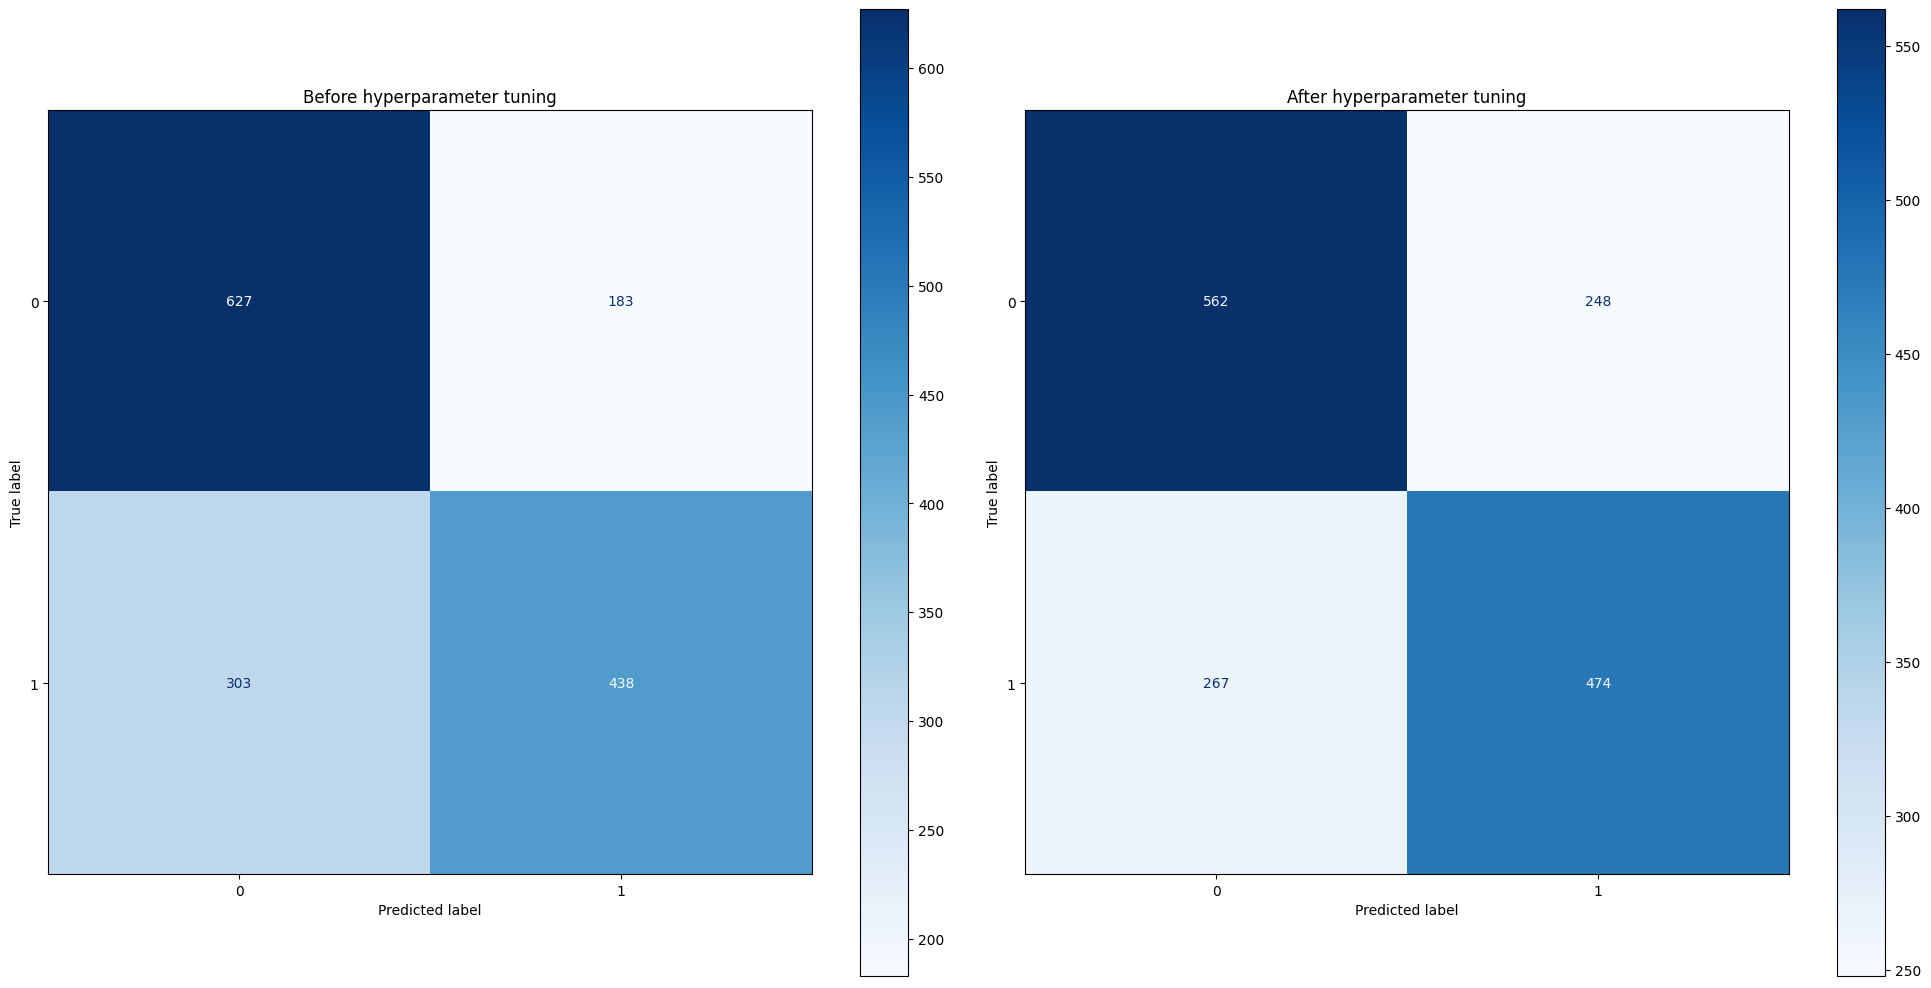

In [70]:
# Set up a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the first confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_predict_before))
disp1.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Before hyperparameter tuning')

# Display the second confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_predict_after))
disp2.plot(ax=axes[1], cmap='Blues')
axes[1].set_title('After hyperparameter tuning')
plt.tight_layout()  # Ensure plots don't overlap
plt.show()

The pictures above display two confusion matrices: one for the benchmark model (left) and one for the model after hyperparameter tuning (right). The results show a significant reduction in false negatives after tuning, while false positives have slightly increased.

In [71]:
# Input loss occurred by false positive and false negative prediction
FP_loss = -500000
FN_loss = -3200000

# Calculate the loss by multiplying FP by FP_loss and adding it to FN multiplied by FN_loss.
loss_before = confusion_matrix(y_test, y_test_predict_before)[0,1]*FP_loss + confusion_matrix(y_test, y_test_predict_before)[1,0]*FN_loss
loss_after = confusion_matrix(y_test, y_test_predict_after)[0,1]*FP_loss + confusion_matrix(y_test, y_test_predict_after)[1,0]*FN_loss

# Print the loss occurred before and after hyperparameter tuning
print(f'Total Loss before hyperparameter tuning = Rp {loss_before}')
print(f'Total Loss after hyperparameter tuning = Rp {loss_after}')

Total Loss before hyperparameter tuning = Rp -1061100000
Total Loss after hyperparameter tuning = Rp -978400000


After calculating the total loss for both before and after hyperparameter tuning, the model utilizing hyperparameter tuning has a lower loss of -Rp 978,400,000 compared to the loss of -Rp 1,061,100,000 before tuning.

## Predict to Test Set (Before and After Hyperparameter tuning) - Conclusion

Since the recall score is lower, the false negatives are also lower and lower loss occured when utilizing the model with hyperparameter tuning compared to the model before tuning. This indicates that the model after tuning exhibits more robust performance, making it the best choice for this classification task.

Although we still need to improve its recall since the value is relatively low (test recall = 0.639676), we will try to optimize its threshold to improve recall.

# Optimize Threshold

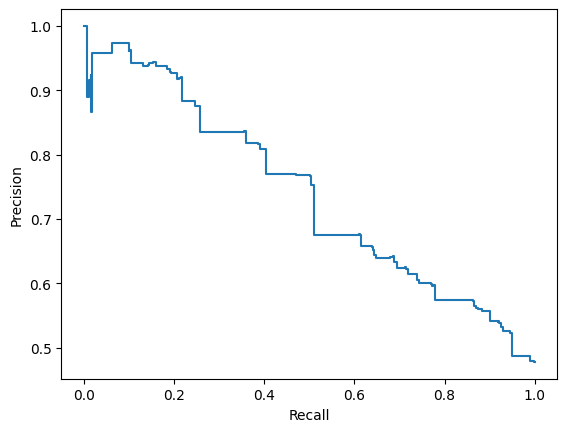

In [72]:
# Best model used is from GridSearch.best_estimator_
best_model = GridSearch.best_estimator_

# Predict probabilities
y_test_predict_proba = best_model.predict_proba(X_test)
y_test_predict_proba = y_test_predict_proba[:, 1]

# Calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_predict_proba)

# Create pr-curve
PrecisionRecallDisplay(precision, recall).plot()
plt.show()

In [73]:
# Store precision, recall, threshold values in dataframe
pr_curve_df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'thresholds': list(thresholds) + [0]
    }).sort_values('recall', ascending=False)

# Showing rows with recall in between 0.75 and 0.9
pr_curve_df[(pr_curve_df['recall'] >= 0.75) & (pr_curve_df['recall'] <= 0.9)]

,precision,recall,thresholds
21,0.560308,0.883941,0.473322
22,0.560515,0.881242,0.476981
23,0.560137,0.879892,0.477224
24,0.560069,0.874494,0.477978
25,0.561632,0.873144,0.478122
26,0.565294,0.870445,0.478739
29,0.571174,0.866397,0.482685
30,0.573214,0.866397,0.483077
28,0.570667,0.866397,0.481053
27,0.570160,0.866397,0.479904


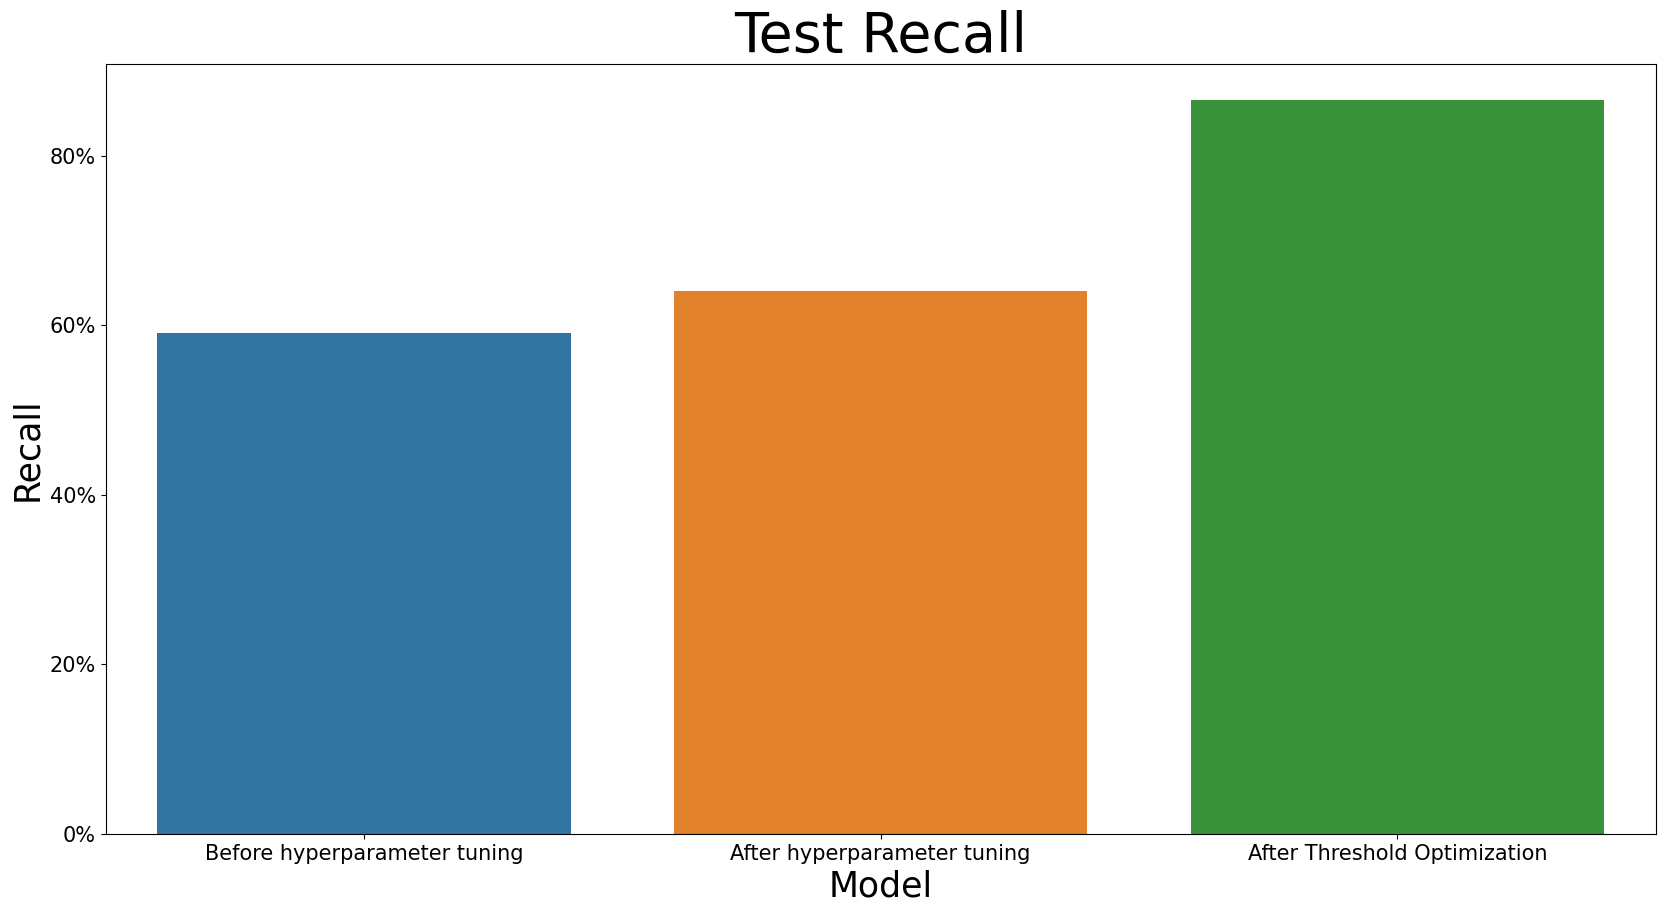

In [74]:
# The best threshold is from row indexed 30, which has high recall and precision
Threshold =0.483077

# Utilize GridSearch.best_estimator_ as best model for threshold optimization
best_model = GridSearch.best_estimator_

best_model.fit(X_train, y_train)
y_train_predict_proba = best_model.predict_proba(X_train)[:, 1]                     # Predict probability
y_test_predict_proba = best_model.predict_proba(X_test)[:, 1]
y_train_predict_thres = np.where(y_train_predict_proba > Threshold, 1, 0)           # Adjust the threshold using np.where
y_test_predict_thres = np.where(y_test_predict_proba > Threshold, 1, 0)

df_acc.loc[len(df_acc)] = {
    'Model': 'After Threshold Optimization',        
    'Train Recall': recall_score(y_train, y_train_predict_thres),
    'Test Recall': recall_score(y_test, y_test_predict_thres)
    }

def final_recall():                                       # Define function to create barplot for all recall
    plt.figure(figsize=(20,10))
    sns.barplot(data=df_acc,x='Model',y='Test Recall')
    plt.xticks(fontsize=15)
    plt.xlabel('Model', fontsize= 25)
    plt.yticks(fontsize=15)
    plt.ylabel('Recall', fontsize= 25)
    plt.title('Test Recall', fontsize= 40)
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))
    plt.show()

final_recall()

From the barplot above, it is evident that the test recall for the model after threshold optimization is significantly higher than both before and after tuning. It's test recall already high at around 85%. This indicates that threshold optimization has successfully improved test recall.

## Optimize Threshold - Calculate Loss

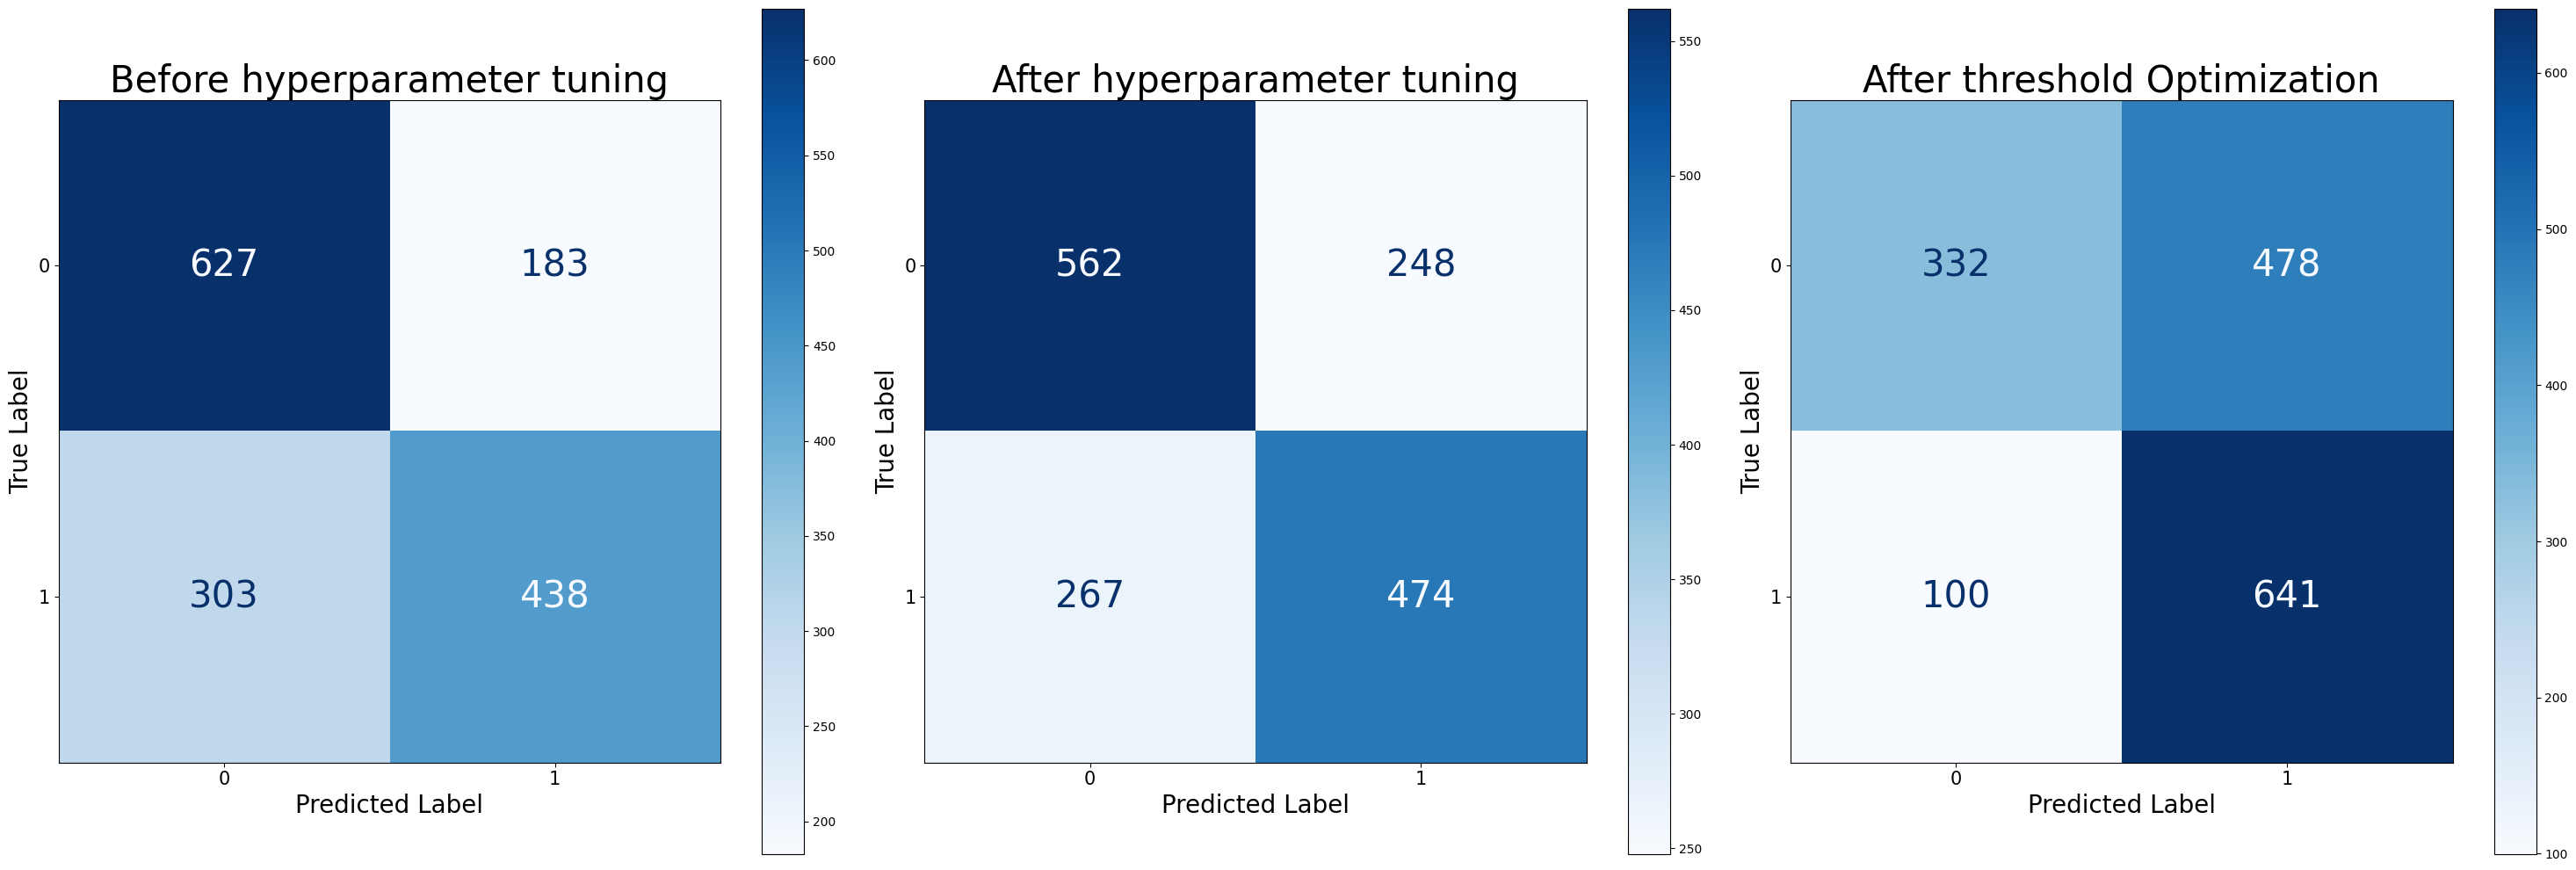

In [75]:
def final_confusion_matrix():                                           # Define function to create all confusion matrix
    # Set up a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    # Display the first confusion matrix
    disp1 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_predict_before))
    disp1.plot(ax=axes[0], cmap='Blues', text_kw={'size': 30})
    axes[0].set_xlabel('Predicted Label', fontsize=20)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].set_ylabel('True Label', fontsize=20)
    axes[0].tick_params(axis='y', labelsize=15)
    axes[0].set_title('Before hyperparameter tuning', fontsize=30)

    # Display the second confusion matrix
    disp2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_predict_after))
    disp2.plot(ax=axes[1], cmap='Blues', text_kw={'size': 30})
    axes[1].set_xlabel('Predicted Label', fontsize=20)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].set_ylabel('True Label', fontsize=20)
    axes[1].tick_params(axis='y', labelsize=15)
    axes[1].set_title('After hyperparameter tuning', fontsize=30)

    # Display the third confusion matrix
    disp3 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_predict_thres))
    disp3.plot(ax=axes[2], cmap='Blues', text_kw={'size': 30})
    axes[2].set_xlabel('Predicted Label', fontsize=20)
    axes[2].tick_params(axis='x', labelsize=15)
    axes[2].set_ylabel('True Label', fontsize=20)
    axes[2].tick_params(axis='y', labelsize=15)
    axes[2].set_title('After threshold Optimization', fontsize=30)

    plt.tight_layout()  # Ensure plots don't overlap
    plt.show()

final_confusion_matrix()

The three confusion matrices above clearly indicate that the number of false negatives is reduced from before to after tuning, and reduced even more significantly as the model threshold is optimized.

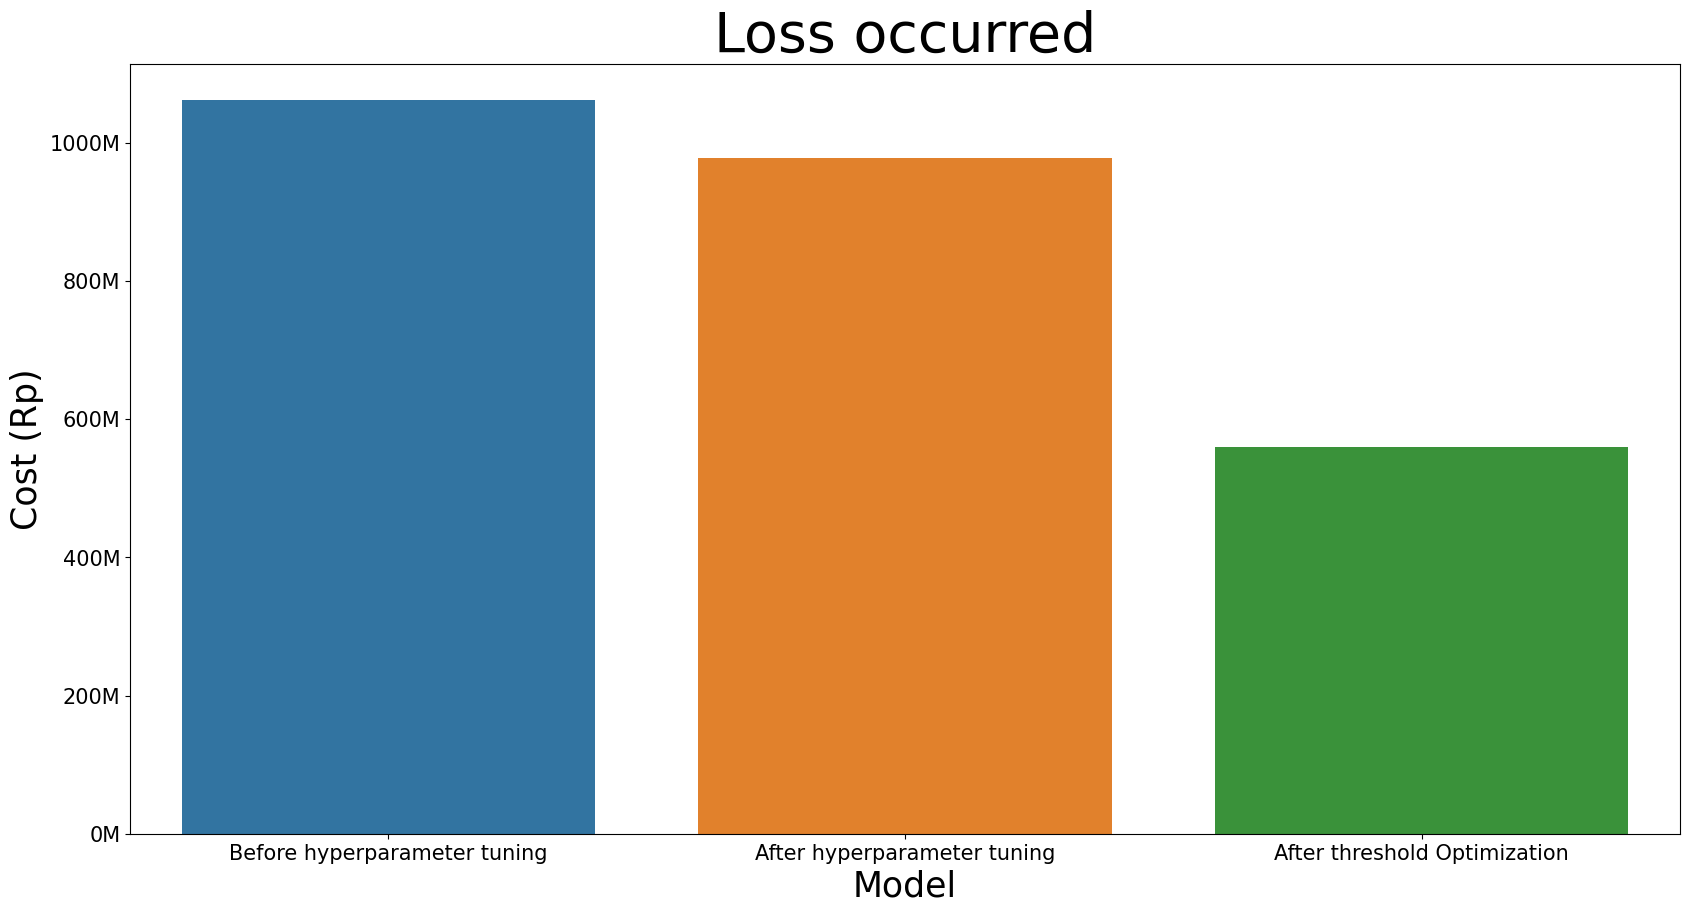

In [76]:
# Calculate total loss after optimized threshold
FP_loss = -500000
FN_loss = -3200000

loss_thres = confusion_matrix(y_test, y_test_predict_thres)[0,1]*FP_loss + confusion_matrix(y_test, y_test_predict_thres)[1,0]*FN_loss

def final_loss_occurred():                                       # Define function to create barplot for loss occurred
    loss_df = pd.DataFrame({
        'Model':['Before hyperparameter tuning','After hyperparameter tuning','After threshold Optimization'],
        'Loss occurred':[-loss_before,-loss_after,-loss_thres]
        })
    plt.figure(figsize=(20,10))
    sns.barplot(data=loss_df,x='Model',y='Loss occurred')
    plt.xticks(fontsize=15)
    plt.xlabel('Model', fontsize= 25)
    plt.yticks(fontsize=15)
    plt.ylabel('Cost (Rp)', fontsize= 25)
    plt.title('Loss occurred', fontsize= 40)
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}M'.format(x / 1e6)))
    plt.show()

final_loss_occurred()

Comparing the total losses before and after hyperparameter tuning, we observe that the loss incurred when optimizing the model threshold is significantly lower. This loss is nearly half of what we experienced with hyperparameter tuning and even less than before tuning.

## Optimized Threshold - Summary

After observing the results, which show higher recall, lower false negatives, and reduced loss, we can conclude that optimizing the model threshold leads to the best performance compared to before and after hyperparameter tuning.

# Feature Importance

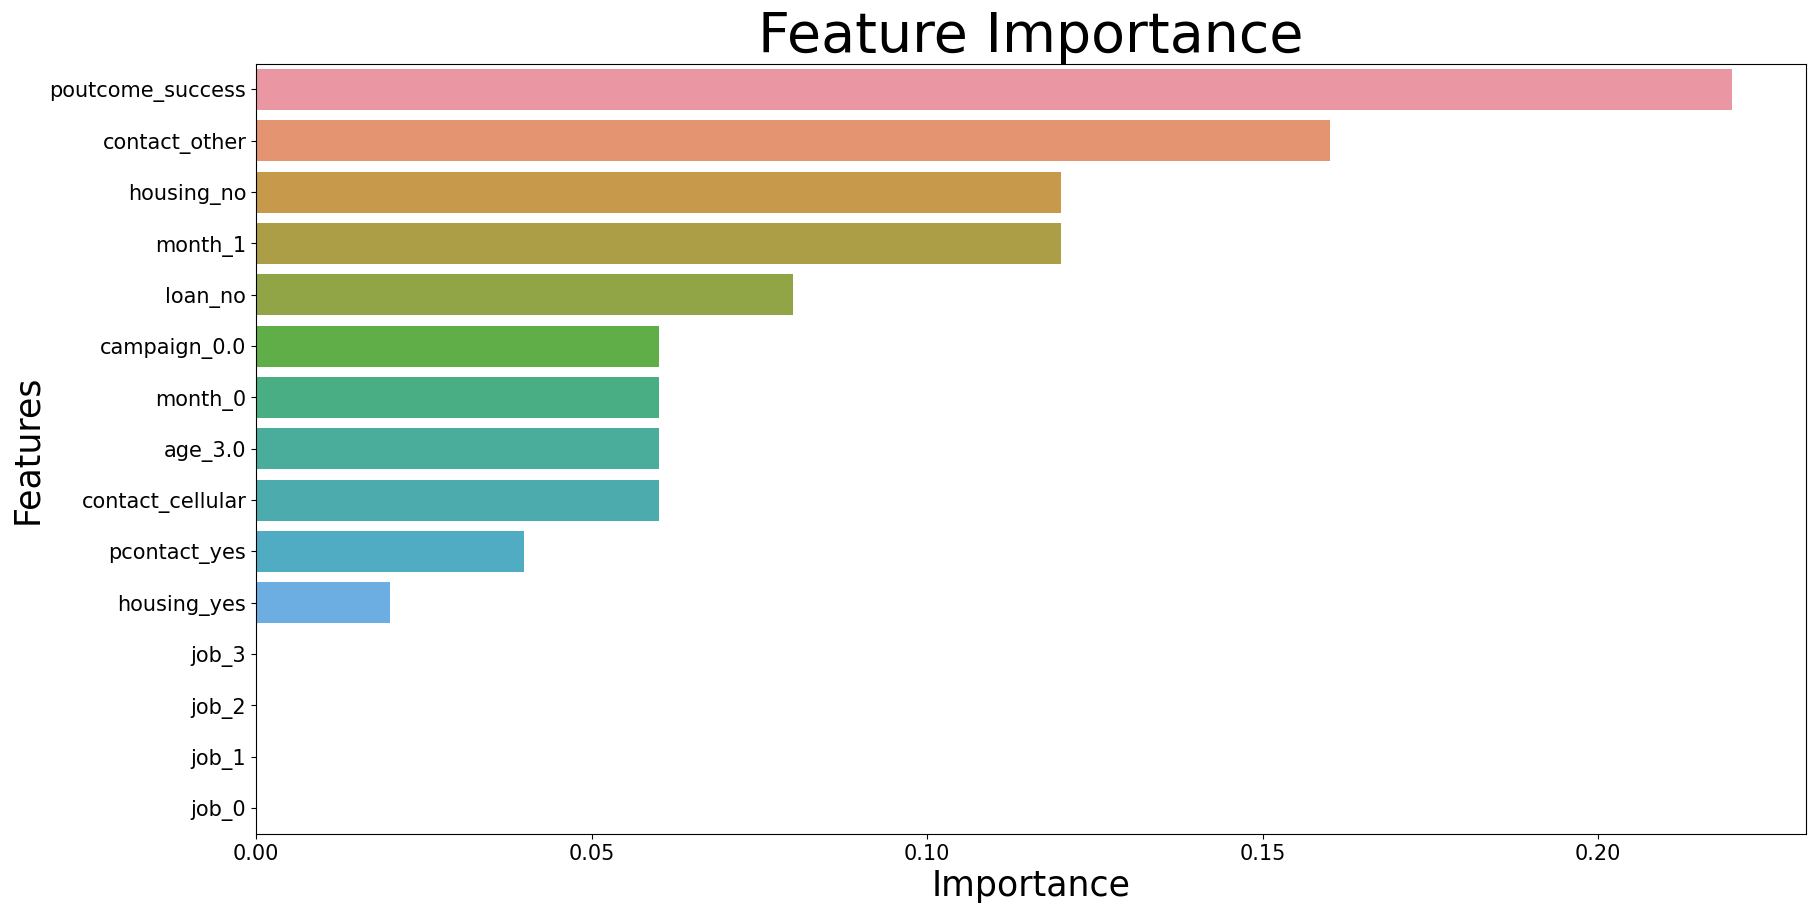

In [77]:
# Store all feature name in list after preprocessing
all_features=[]
for n_transform in range(3):
    all_features += list(transformer.transformers_[n_transform][1].get_feature_names_out())


def feature_imporance():                                # Function to create barplot for feature importance
    n_features = len(all_features)
    feature_df = pd.DataFrame({
                                'importance':best_model['modeling'].feature_importances_,
                                'features':all_features
                            }).sort_values(by='importance', ascending=False).head(n_features)
    feature_df.reset_index(drop=True, inplace=True)
    feature_df.index += 1

    # Create barplot for visualization
    plt.figure(figsize=(20,10))
    sns.barplot(data=feature_df.head(15),x='importance',y='features')
    plt.xticks(fontsize=15)
    plt.xlabel('Importance', fontsize= 25)
    plt.yticks(fontsize=15)
    plt.ylabel('Features', fontsize= 25)
    plt.title('Feature Importance', fontsize= 40)
    plt.show()

feature_imporance()

The bar plot above displays the 15 most important features. The top-ranked feature is 'poutcome_success,' followed by 'contact_other,' 'housing_no,' and so on. Upon closer examination, it becomes evident that only 11 out of these 15 features are truly important, while the others are not as significant. This suggests that these less important features can be eliminated when creating a new model. The purpose of this elimination is to focus the machine learning process on the most crucial features, with the hope of improving the model's performance.

# Conclusion

**Conclusion:**

The machine learning model, with an 85% recall rate, has been a great success for our term deposit marketing. It means the model is good at catching customers who are likely to say "yes" to a term deposit, which saves us money.

**Key Points:**

1. **Less Missed Opportunities:** The model helps us find more customers who want term deposits, reducing the chances of missing them.

2. **Saving Money:** By using the model, we use our resources more wisely and spend less on customers who won't subscribe.

3. **Customer Focus:** We're now better at targeting customers who are interested, making their experience better.

4. **Keep Improving:** We should keep making the model better over time with new data and adapt to changes.

5. **Balance is Key:** While finding more interested customers is good, we need to be careful not to target too many who aren't interested. Finding the right balance is important.

In short, the model's high recall rate is a big win for our marketing, helping us find more potential customers while saving us money. We'll keep using this success to improve our marketing strategies.

# Recomendation

**Recommendation:**

1. **Keep an Eye on the Model:** Keep checking how well the model is doing regularly. If something seems off, fix it.

2. **Talk to the Marketing Team:** Listen to what the marketing team says about the model. They can help make it even better.

3. **Balance is Important:** The model is good at finding interested customers, but don't go too far and annoy customers who aren't interested.

4. **Use Fresh Data:** Always use the newest data to keep the model smart and up-to-date.

5. **Try New Things:** Experiment with different ways to talk to customers based on what the model tells you.

Following these simple steps will help us keep getting better at marketing term deposits and making customers happy.

# # Save Final Model

In [78]:
final_model = GridSearch.best_estimator_
final_model.fit(X,y)

# Save the model to a file
pickle.dump(final_model, open('Vincent_FinalModel_BeforeThreshold.sav','wb'))


The final model saved is the one that performs the best after hyperparameter tuning. However, it's important to note that the best results can only be achieved after optimizing its threshold, which is set to 0.483077. Therefore, before using the model for predictions, remember to set its threshold to 0.483077.